%md
# 🏥 CDC Vaccine Coverage ETL Pipeline
### Medallion Architecture: Bronze → Silver → Gold

---

## 🥉 Bronze Layer - Raw Data Ingestion
**Author:** Fahim Akbar  
**Date:** February 2026  
**Source:** CDC National Immunization Survey - Monthly Cumulative Coverage by States  
**URL:** https://data.cdc.gov  

---

### Purpose
Ingest raw CDC vaccination coverage data with zero transformations. 
The Bronze layer preserves the original source data exactly as received, 
serving as the immutable foundation for all downstream processing.

### Input
| Detail | Value |
|--------|-------|
| File Format | CSV |
| File Name | Monthly_Cumulative_N..._States_20260213.csv |
| Source | CDC National Immunization Survey |
| Environment | Databricks Community Edition |

### Output
| Detail | Value |
|--------|-------|
| Table Name | bronze_cdc_vaccine_raw |
| Format | Delta |
| Rows Loaded | 252 |
| Columns | 7 |

### Schema
| Column | Type | Description |
|--------|------|-------------|
| Season | string | Flu/vaccine season (e.g. 2025-26) |
| Month | string | Reporting month |
| Numerator | string | Count of vaccinated individuals |
| Population | string | Total population in group |
| Jurisdiction | string | U.S. state or territory |
| Estimate | double | Vaccination rate percentage |
| Age_group_label | string | Demographic age group |

### Notes
> ⚠️ Numerator and Population intentionally kept as strings in Bronze.  
> Type casting and null handling performed in Silver layer.  
> "Not Submitted" values present in Numerator - preserved as-is in Bronze.

In [0]:
# ============================================
# BRONZE LAYER - Raw Data Ingestion
# ============================================

# Unity Catalog Volume path (updated from DBFS)
raw_file_path = "/Volumes/workspace/default/cdc_vaccine_data/Monthly_Cumulative_Number_and_Percent_of_Children__8_Months_Who_Received_1+_Monoclonal_Antibody_Doses_by_Jurisdiction,_United_States_20260213.csv"

df_bronze = (spark.read
    .format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")
    .option("escape", '"')
    .load(raw_file_path))

print("✅ Bronze layer loaded successfully!")

✅ Bronze layer loaded successfully!


In [0]:
# How many rows and columns?
print(f"Rows: {df_bronze.count():,}")
print(f"Columns: {len(df_bronze.columns)}")

display(df_bronze.limit(5))

Rows: 252
Columns: 7


Season,Month,Numerator,Population,Jurisdiction,Estimate,Age_group_label
2025-26,DEC,Not Submitted,null,Alaska,null,0-7 months
2025-26,DEC,Not Submitted,null,Alabama,null,0-7 months
2025-26,DEC,Not Submitted,null,Arkansas,null,0-7 months
2025-26,DEC,Not Submitted,null,American Samoa,null,0-7 months
2025-26,DEC,Not Submitted,null,Arizona,null,0-7 months


In [0]:
df_bronze.printSchema()

root
 |-- Season: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Numerator: string (nullable = true)
 |-- Population: string (nullable = true)
 |-- Jurisdiction: string (nullable = true)
 |-- Estimate: double (nullable = true)
 |-- Age_group_label: string (nullable = true)



In [0]:
# ============================================
# BRONZE LAYER - Save as Delta Table
# ============================================

(df_bronze.write
    .format("delta")
    .mode("overwrite")
    .saveAsTable("bronze_cdc_vaccine_raw"))

print("Bronze Delta table saved!")
print("Table: bronze_cdc_vaccine_raw")
print(f"Total records preserved: {df_bronze.count():,}")

Bronze Delta table saved!
Table: bronze_cdc_vaccine_raw
Total records preserved: 252


## Silver Layer - Cleaning & Transformation
**Purpose:** Clean raw Bronze data, fix data types, 
handle nulls and invalid values, standardize columns  
**Input:** bronze_cdc_vaccine_raw  
**Output:** silver_cdc_vaccine_clean

In [0]:
# ============================================
# SILVER LAYER - Cleaning & Transformation
# ============================================

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType

# Read from Bronze Delta table
df_silver = spark.table("bronze_cdc_vaccine_raw")

df_silver = (df_silver

    # Step 1: Replace "Not Submitted" with null in Numerator
    .withColumn("Numerator",
        F.when(F.col("Numerator") == "Not Submitted", None)
        .otherwise(F.col("Numerator")))

    # Step 2: Remove commas and cast Numerator and Population to numeric
    .withColumn("Numerator", F.regexp_replace(F.col("Numerator"), ",", ""))
    .withColumn("Population", F.regexp_replace(F.col("Population"), ",", ""))
    .withColumn("Numerator", F.col("Numerator").cast(DoubleType()))
    .withColumn("Population", F.col("Population").cast(DoubleType()))

    # Step 3: Standardize Month to uppercase
    .withColumn("Month", F.upper(F.col("Month")))

    # Step 4: Standardize column names to snake_case
    .withColumnRenamed("Season", "season")
    .withColumnRenamed("Month", "month")
    .withColumnRenamed("Numerator", "numerator")
    .withColumnRenamed("Population", "population")
    .withColumnRenamed("Jurisdiction", "jurisdiction")
    .withColumnRenamed("Estimate", "estimate_pct")
    .withColumnRenamed("Age_group_label", "age_group")

    # Step 5: Drop rows where BOTH estimate AND numerator are null
    # (completely empty records with no useful data)
    .filter(
        F.col("estimate_pct").isNotNull() | 
        F.col("numerator").isNotNull())
)

print("Silver transformation complete!")
print(f"Records after cleaning: {df_silver.count():,}")
print(f"Records dropped: {df_bronze.count() - df_silver.count():,}")

Silver transformation complete!
Records after cleaning: 24
Records dropped: 228


In [0]:
# Let's understand our data better before saving
# Check how many rows have BOTH nulls vs just one null

df_bronze_check = spark.table("bronze_cdc_vaccine_raw")

print("Records where Estimate IS NOT null:")
print(df_bronze_check.filter(
    F.col("Estimate").isNotNull()).count())

print("\nRecords where Numerator != 'Not Submitted':")
print(df_bronze_check.filter(
    F.col("Numerator") != "Not Submitted").count())

print("\nUnique values in Numerator column:")
display(df_bronze_check.groupBy("Numerator")
    .count()
    .orderBy("count", ascending=False))

Records where Estimate IS NOT null:
24

Records where Numerator != 'Not Submitted':
24

Unique values in Numerator column:


Numerator,count
Not Submitted,228
665,1
"25,610",1
68,1
796,1
"2,683",1
"11,501",1
"16,504",1
"7,055",1
"3,585",1


In [0]:
# Instead of dropping them, flag them
df_silver = df_silver.withColumn("data_quality_flag",
    F.when(F.col("estimate_pct").isNull(), "No Data Submitted")
    .otherwise("Valid"))
# Keep ALL rows but flag the bad ones

In [0]:
# Save Silver Delta table
(df_silver.write
    .format("delta")
    .mode("overwrite")
    .saveAsTable("silver_cdc_vaccine_clean"))

print("Silver Delta table saved!")

Silver Delta table saved!


%md
## Gold Layer - Aggregated Insights
**Purpose:** Business-level aggregations for analysis and visualization  
**Input:** silver_cdc_vaccine_clean  
**Output:** gold_cdc_vaccine_insights

In [0]:
# ============================================
# GOLD LAYER - Read from Silver
# ============================================

df_silver = spark.table("silver_cdc_vaccine_clean")

# Quick peek at what clean data looks like
display(df_silver)

season,month,numerator,population,jurisdiction,estimate_pct,age_group,data_quality_flag
2025-26,DEC,122609.0,302909.0,California,0.4048,0-7 months,Valid
2025-26,DEC,1923.0,6010.0,District of Columbia,0.32,0-7 months,Valid
2025-26,DEC,32022.0,93527.0,Georgia,0.3424,0-7 months,Valid
2025-26,DEC,18777.0,59201.0,Indiana,0.3172,0-7 months,Valid
2025-26,DEC,10894.0,40041.0,Louisiana,0.2721,0-7 months,Valid
2025-26,DEC,2977.0,8544.0,South Dakota,0.3484,0-7 months,Valid
2025-26,NOV,102650.0,269252.0,California,0.3812,0-7 months,Valid
2025-26,NOV,1805.0,5342.0,District of Columbia,0.3379,0-7 months,Valid
2025-26,NOV,25610.0,83135.0,Georgia,0.3081,0-7 months,Valid
2025-26,NOV,16737.0,52623.0,Indiana,0.3181,0-7 months,Valid


%md
## 🥇 Gold Layer - Aggregated Insights
**Purpose:** Business-level aggregations ready for visualization and reporting  
**Input:** silver_cdc_vaccine_clean  
**Output:** gold_cdc_vaccine_insights  

### Insights Generated
1. Vaccination rate by state (latest month)
2. Vaccination trend by month across all states
3. State ranking by coverage percentage

In [0]:
# ============================================
# GOLD LAYER - Aggregated Insights
# ============================================

from pyspark.sql import functions as F

df_silver = spark.table("silver_cdc_vaccine_clean")

# Convert estimate_pct to readable percentage (0.4048 → 40.48%)
df_gold = df_silver.withColumn(
    "vaccination_rate_pct",
    F.round(F.col("estimate_pct") * 100, 2)
)

print("Gold base layer ready!")
display(df_gold)

Gold base layer ready!


season,month,numerator,population,jurisdiction,estimate_pct,age_group,data_quality_flag,vaccination_rate_pct
2025-26,DEC,122609.0,302909.0,California,0.4048,0-7 months,Valid,40.48
2025-26,DEC,1923.0,6010.0,District of Columbia,0.32,0-7 months,Valid,32.0
2025-26,DEC,32022.0,93527.0,Georgia,0.3424,0-7 months,Valid,34.24
2025-26,DEC,18777.0,59201.0,Indiana,0.3172,0-7 months,Valid,31.72
2025-26,DEC,10894.0,40041.0,Louisiana,0.2721,0-7 months,Valid,27.21
2025-26,DEC,2977.0,8544.0,South Dakota,0.3484,0-7 months,Valid,34.84
2025-26,NOV,102650.0,269252.0,California,0.3812,0-7 months,Valid,38.12
2025-26,NOV,1805.0,5342.0,District of Columbia,0.3379,0-7 months,Valid,33.79
2025-26,NOV,25610.0,83135.0,Georgia,0.3081,0-7 months,Valid,30.81
2025-26,NOV,16737.0,52623.0,Indiana,0.3181,0-7 months,Valid,31.81


In [0]:
# ============================================
# GOLD INSIGHT 1 - Latest Vaccination Rate by State
# ============================================

gold_by_state = (df_gold
    .filter(F.col("month") == "DEC")  # most recent month
    .select(
        "jurisdiction",
        "vaccination_rate_pct",
        "numerator",
        "population",
        "month",
        "season"
    )
    .orderBy("vaccination_rate_pct", ascending=False)
)

print("Insight 1: Vaccination Rate by State (December 2025)")
display(gold_by_state)

Insight 1: Vaccination Rate by State (December 2025)


jurisdiction,vaccination_rate_pct,numerator,population,month,season
California,40.48,122609.0,302909.0,DEC,2025-26
South Dakota,34.84,2977.0,8544.0,DEC,2025-26
Georgia,34.24,32022.0,93527.0,DEC,2025-26
District of Columbia,32.0,1923.0,6010.0,DEC,2025-26
Indiana,31.72,18777.0,59201.0,DEC,2025-26
Louisiana,27.21,10894.0,40041.0,DEC,2025-26


In [0]:
# ============================================
# GOLD INSIGHT 2 - Monthly Trend by State
# ============================================

# Define month order for proper sorting
month_order = F.when(F.col("month") == "OCT", 1)\
               .when(F.col("month") == "NOV", 2)\
               .when(F.col("month") == "DEC", 3)

gold_monthly_trend = (df_gold
    .select(
        "jurisdiction",
        "month",
        "vaccination_rate_pct",
        "numerator",
        "population"
    )
    .withColumn("month_order", month_order)
    .orderBy("jurisdiction", "month_order")
)

print("Insight 2: Monthly Vaccination Trend by State")
display(gold_monthly_trend)

Insight 2: Monthly Vaccination Trend by State


jurisdiction,month,vaccination_rate_pct,numerator,population,month_order
California,SEP,1.78,3585.0,201939.0,null
California,OCT,27.87,65670.0,235596.0,1
California,NOV,38.12,102650.0,269252.0,2
California,DEC,40.48,122609.0,302909.0,3
District of Columbia,SEP,1.7,68.0,4007.0,null
District of Columbia,OCT,30.64,1432.0,4674.0,1
District of Columbia,NOV,33.79,1805.0,5342.0,2
District of Columbia,DEC,32.0,1923.0,6010.0,3
Georgia,SEP,2.29,1429.0,62352.0,null
Georgia,OCT,22.69,16504.0,72743.0,1


In [0]:
# ============================================
# GOLD INSIGHT 3 - State Rankings Summary
# ============================================

gold_state_ranking = (df_gold
    .groupBy("jurisdiction")
    .agg(
        F.round(F.avg("vaccination_rate_pct"), 2).alias("avg_rate_pct"),
        F.max("vaccination_rate_pct").alias("peak_rate_pct"),
        F.min("vaccination_rate_pct").alias("lowest_rate_pct"),
        F.sum("numerator").alias("total_vaccinated"),
        F.round(F.avg("population"), 0).alias("avg_population")
    )
    .orderBy("avg_rate_pct", ascending=False)
)

print("Insight 3: State Rankings by Average Vaccination Rate")
display(gold_state_ranking)

Insight 3: State Rankings by Average Vaccination Rate


jurisdiction,avg_rate_pct,peak_rate_pct,lowest_rate_pct,total_vaccinated,avg_population
California,27.06,40.48,1.78,294514.0,252424.0
District of Columbia,24.53,33.79,1.7,5228.0,5008.0
South Dakota,24.43,35.33,0.51,7485.0,7120.0
Indiana,22.63,31.81,2.02,47811.0,49334.0
Georgia,22.51,34.24,2.29,75565.0,77939.0
Louisiana,19.9,27.26,2.49,28318.0,33368.0


In [0]:
# ============================================
# GOLD LAYER - Save Delta Table
# ============================================

(df_gold.write
    .format("delta")
    .mode("overwrite")
    .saveAsTable("gold_cdc_vaccine_insights"))

print("Gold Delta table saved!")
print("Table: gold_cdc_vaccine_insights")
print(f"Total records: {df_gold.count():,}")

Gold Delta table saved!
Table: gold_cdc_vaccine_insights
Total records: 24


## Visualizations
**Purpose:** Translate Gold layer insights into clear, compelling charts  
**Charts:**
1. Bar chart - Vaccination rate by state (December 2025)
2. Line chart - Monthly trend by state (SEP→DEC)
3. Horizontal bar - State rankings by average rate

In [0]:
import matplotlib
print(matplotlib.__version__)

3.10.0


In [0]:
%pip install matplotlib==3.7.1

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
# ============================================
# RELOAD ALL TABLES AFTER KERNEL RESTART
# ============================================

from pyspark.sql import functions as F

# Reload from saved Delta tables
df_bronze = spark.table("bronze_cdc_vaccine_raw")
df_silver = spark.table("silver_cdc_vaccine_clean")
df_gold   = spark.table("gold_cdc_vaccine_insights")

# Rebuild Gold insight DataFrames for plotting
month_order = F.when(F.col("month") == "SEP", 0)\
               .when(F.col("month") == "OCT", 1)\
               .when(F.col("month") == "NOV", 2)\
               .when(F.col("month") == "DEC", 3)

gold_by_state = (df_gold
    .filter(F.col("month") == "DEC")
    .select("jurisdiction", "vaccination_rate_pct",
            "numerator", "population", "month", "season")
    .orderBy("vaccination_rate_pct", ascending=False))

gold_monthly_trend = (df_gold
    .select("jurisdiction", "month",
            "vaccination_rate_pct", "numerator", "population")
    .withColumn("month_order", month_order)
    .orderBy("jurisdiction", "month_order"))

gold_state_ranking = (df_gold
    .groupBy("jurisdiction")
    .agg(
        F.round(F.avg("vaccination_rate_pct"), 2).alias("avg_rate_pct"),
        F.max("vaccination_rate_pct").alias("peak_rate_pct"),
        F.min("vaccination_rate_pct").alias("lowest_rate_pct"),
        F.sum("numerator").alias("total_vaccinated"),
        F.round(F.avg("population"), 0).alias("avg_population")
    )
    .orderBy("avg_rate_pct", ascending=False))

print("All Delta tables reloaded!")
print(f"Bronze: {df_bronze.count():,} rows")
print(f"Silver: {df_silver.count():,} rows")
print(f"Gold:   {df_gold.count():,} rows")
print("Gold DataFrames rebuilt and ready for plotting!")

All Delta tables reloaded!
Bronze: 252 rows
Silver: 24 rows
Gold:   24 rows
Gold DataFrames rebuilt and ready for plotting!


In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pdy

pd_by_state = gold_by_state.toPandas()
pd_monthly = gold_monthly_trend.toPandas()
pd_ranking = gold_state_ranking.toPandas()

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "#f5f5f5",
    "axes.grid": True,
    "grid.color": "white",
    "font.size": 11
})
COLORS = ["#2196F3", "#1976D2", "#1565C0", "#0D47A1", "#082C6B", "#051A40"]

print("✅ Visualization libraries ready!")

✅ Visualization libraries ready!


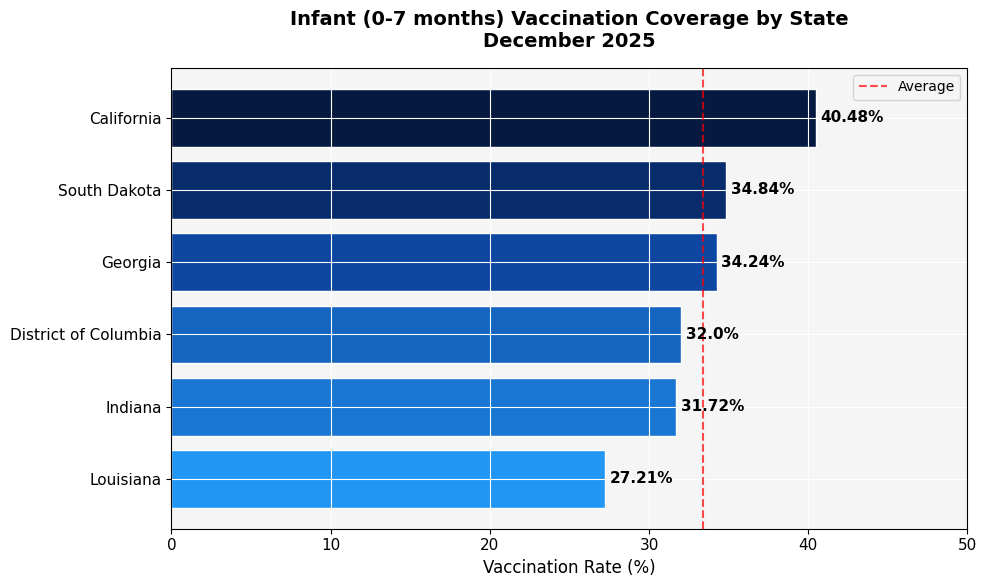

Chart 1 saved!


In [0]:
# ============================================
# CHART 1 - Vaccination Rate by State (DEC 2025)
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

pd_by_state_sorted = pd_by_state.sort_values(
    "vaccination_rate_pct", ascending=True)

bars = ax.barh(
    pd_by_state_sorted["jurisdiction"],
    pd_by_state_sorted["vaccination_rate_pct"],
    color=COLORS,
    edgecolor="white"
)

for bar, val in zip(bars, pd_by_state_sorted["vaccination_rate_pct"]):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2,
            f"{val}%", va="center", fontsize=11, fontweight="bold")

ax.set_xlabel("Vaccination Rate (%)", fontsize=12)
ax.set_title(
    "Infant (0-7 months) Vaccination Coverage by State\nDecember 2025",
    fontsize=14, fontweight="bold", pad=15)
ax.set_xlim(0, 50)
ax.axvline(x=pd_by_state["vaccination_rate_pct"].mean(),
           color="red", linestyle="--", alpha=0.7, label="Average")
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("chart1_vaccination_by_state.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart 1 saved!")

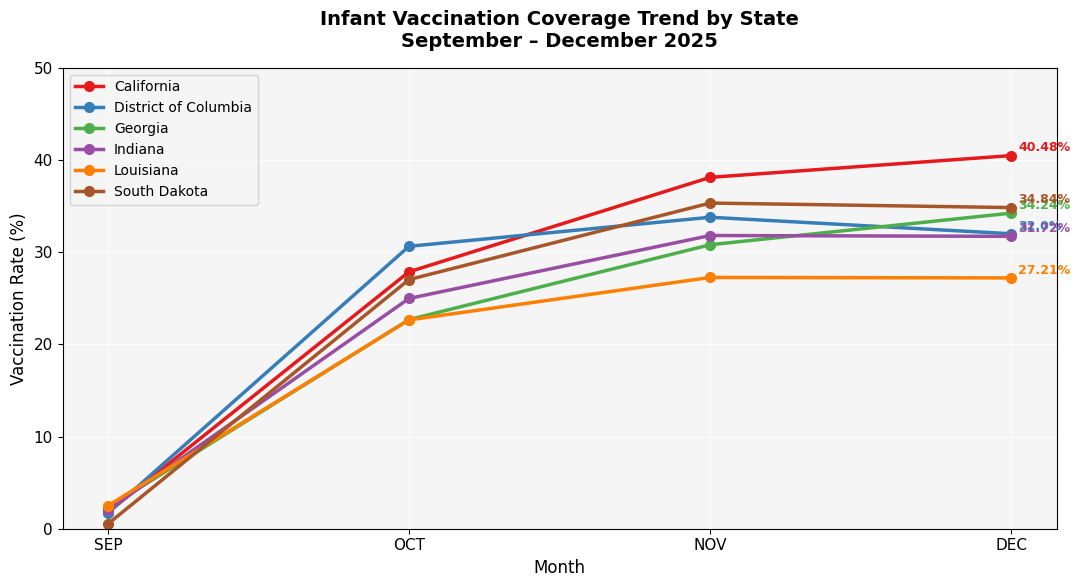

Chart 2 saved!


In [0]:
# ============================================
# CHART 2 - Monthly Trend by State (SEP→DEC)
# ============================================

month_map = {"SEP": 0, "OCT": 1, "NOV": 2, "DEC": 3}
pd_monthly["month_num"] = pd_monthly["month"].map(month_map)
pd_monthly_sorted = pd_monthly.sort_values(["jurisdiction", "month_num"])

fig, ax = plt.subplots(figsize=(11, 6))

states = pd_monthly_sorted["jurisdiction"].unique()
line_colors = ["#e41a1c","#377eb8","#4daf4a",
               "#984ea3","#ff7f00","#a65628"]

for i, state in enumerate(states):
    state_data = pd_monthly_sorted[
        pd_monthly_sorted["jurisdiction"] == state]
    ax.plot(
        state_data["month"],
        state_data["vaccination_rate_pct"],
        marker="o", linewidth=2.5,
        markersize=7, label=state,
        color=line_colors[i]
    )
    last = state_data.iloc[-1]
    ax.annotate(f"{last['vaccination_rate_pct']}%",
                xy=(last["month"], last["vaccination_rate_pct"]),
                xytext=(5, 3), textcoords="offset points",
                fontsize=9, color=line_colors[i], fontweight="bold")

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Vaccination Rate (%)", fontsize=12)
ax.set_title(
    "Infant Vaccination Coverage Trend by State\nSeptember – December 2025",
    fontsize=14, fontweight="bold", pad=15)
ax.legend(loc="upper left", fontsize=10)
ax.set_ylim(0, 50)

plt.tight_layout()
plt.savefig("chart2_monthly_trend.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart 2 saved!")

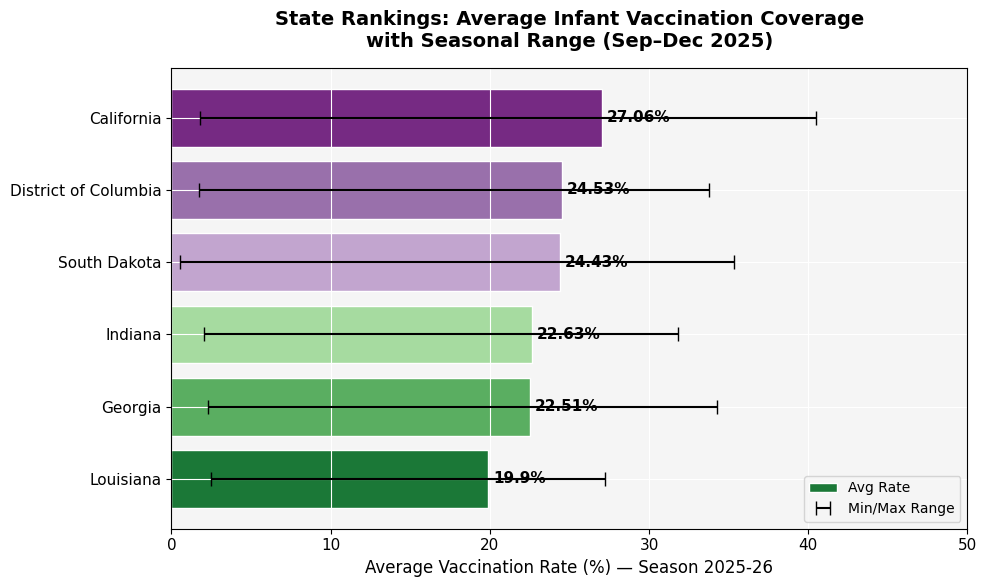

Chart 3 saved!


In [0]:
# ============================================
# CHART 3 - State Rankings with Min/Max Range
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

pd_ranking_sorted = pd_ranking.sort_values(
    "avg_rate_pct", ascending=True)

bar_colors = ["#1b7837","#5aae61","#a6dba0",
              "#c2a5cf","#9970ab","#762a83"]

bars = ax.barh(
    pd_ranking_sorted["jurisdiction"],
    pd_ranking_sorted["avg_rate_pct"],
    color=bar_colors,
    edgecolor="white",
    label="Avg Rate"
)

ax.errorbar(
    pd_ranking_sorted["avg_rate_pct"],
    pd_ranking_sorted["jurisdiction"],
    xerr=[
        pd_ranking_sorted["avg_rate_pct"] - pd_ranking_sorted["lowest_rate_pct"],
        pd_ranking_sorted["peak_rate_pct"] - pd_ranking_sorted["avg_rate_pct"]
    ],
    fmt="none", color="black", capsize=5,
    linewidth=1.5, label="Min/Max Range"
)

for bar, val in zip(bars, pd_ranking_sorted["avg_rate_pct"]):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2,
            f"{val}%", va="center", fontsize=11, fontweight="bold")

ax.set_xlabel("Average Vaccination Rate (%) — Season 2025-26", fontsize=12)
ax.set_title(
    "State Rankings: Average Infant Vaccination Coverage\nwith Seasonal Range (Sep–Dec 2025)",
    fontsize=14, fontweight="bold", pad=15)
ax.legend(fontsize=10)
ax.set_xlim(0, 50)

plt.tight_layout()
plt.savefig("chart3_state_rankings.png", dpi=150, bbox_inches="tight")
plt.show()
print("Chart 3 saved!")